# Smart Construction Document Manager (SCDM)


## Problem Statement
Document management is a crucial need for the construction projects. The project documents produced during the course of the project; from inception and planning through design and construction, are vital to the project success.

The documents such as contracts, payment receipts, agreements, approval letters, drawings, meeting minutes and so on which are produced in one stage become critical as the requirement/prerequisite in the next stage of the project. The construction project documents are also considered as the project asset. They are essential for the following tasks during the project lifecyle:

- Project activities such as planning, design and construction
- Operation and maintenance during the facility's service
- Project warranties
- Lawsuits


## Manual Document Management Challenges

The document management for the construction project can be very challenging. An average medium size construction project can produce roughly +4,000 documents.

This single task not only consumes a big chunk of time out of the project managers's schedule but also requires rigorous due diligence and vigilance. The project managers needs to 1) download the project files from different sources such as email, flash drives, DVDs, web-based applications, Dropbox, Google drive and so on, 2) organize them, and 3) upload them based on their content to the project document various folders. The following is an example of the construction project file index:

<img src = "construction file index.png">


## Project Objective

This project aims to create a Classification Model to suggest the destination folder for the uploaded file based on their names and contents. The tool, called SCDM, assists PMs to organize and upload the documents to the project document repository system.


## Application

The recommender system can perform in the same fashion as the Gmail text recommender does. For the inbox emails with attachment, the system can recommend the destination folder when use decides to copy the attachment to their Google drive.

<img src = "application.png">

## Data Collection

I picked randomly seven (7) medium to large constructoin projects from the database to which I have access. Here is the list of the projects:


In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [3]:
import sqlite3
conn = sqlite3.connect("project_dir.db")
cursor = conn.cursor()

In [5]:
sql = "SELECT project_id,doc_size_mb,doc_num,folder_path FROM project limit 7"

proj_df = pd.read_sql(sql, conn)
proj_df

,project_id,doc_size_mb,doc_num,folder_path
0,proj_001,100000.0,26639.0,G:\My_Projects\SmartCDM\A_James_Clark
1,proj_002,6110.0,2560.0,G:\My_Projects\SmartCDM\CAMBRIDGE_HALL_RENOVATION
2,proj_003,72200.0,34996.0,G:\My_Projects\SmartCDM\EDWARD_ST_JOHN
3,proj_004,21200.0,14547.0,G:\My_Projects\SmartCDM\FSU_CCIT
4,proj_005,74600.0,66428.0,G:\My_Projects\SmartCDM\PHYSICAL_SCIENCES
5,proj_006,17300.0,10031.0,G:\My_Projects\SmartCDM\PRINCE_FREDERICK_HALL
6,proj_007,14600.0,8367.0,G:\My_Projects\SmartCDM\STUDENT_CENTER


## Raw data prepration

The raw data was retrieved by the following two steps:

### Step1) Creating the list of the project files
I developed a code to create the list of all the project files and I stored the file name, extension, size (bytes), destination path and the date last modified.

In [4]:
sql = "SELECT {0} FROM {1}".format("[project_file].*", "[project_file]")

proj_dir_df = pd.read_sql(sql, conn)
proj_dir_df.sample(7)

,project_id,file_path,date_updated,size,file_name,file_ext
151764,proj_006,F.02 Requests for Information\F.02.02 RFIs,05/22/2014 03:52 PM,16485,RFI-00336.0-AHU-3_and_5_Reheat.htm,htm
71042,proj_004,F.01 Construction Administration\F.01.01 Const...,06/20/2013 04:24 PM,529843,11 E105 MEDIUM VOLTAGE SITE PLAN - NEW WORK - ...,dwf
121838,proj_005,F.05 Photos\2012\2012.12\121218 PSC Site Photos,06/20/2013 04:50 PM,2240385,DSCN5363.JPG,JPG
128803,proj_005,F.05 Photos\Webcam\20101031,12/17/2013 09:59 AM,591368,1288541206.jpg,jpg
72481,proj_004,F.01 Construction Administration\F.01.01 Const...,06/20/2013 05:25 PM,24432,07 1326 - SELF-ADHERING SHEET WATERPROOFING.pdf,pdf
158607,proj_007,F.01 Construction Administration\F.01.01 Const...,07/02/2013 04:57 PM,46072,260526 Ground and Bond.pdf,pdf
49810,proj_003,F.01 Construction Administration\F.01.02 Archi...,03/09/2015 09:18 AM,11657216,ESJ_LTC_MOCKUP - VE.rvt,rvt


Those seven (7) projects include __164,031__ files with size of __329.6GB__.

In [10]:
print("The total number of the files in the data sample = {}".format(len(proj_dir_df)))

print("The total size of the files in the data sample = {}".format(proj_dir_df['size'].sum(axis=0)))

The total number of the files in the data sample = 164031
The total size of the files in the data sample = 329596595085


Here is also some statistics regarding the project files gathered in the dataset:

In [12]:
dir_sum_df = proj_dir_df.groupby('file_ext').agg({'file_name':'count', 'size':'sum'}).reset_index()

In [21]:
dir_plt_df = dir_sum_df.sort_values(['file_name'], ascending=False).head(20).set_index('file_ext')
dir_plt_df

,file_name,size
file_ext,,
pdf,87782,169410773200
JPG,28192,40240385583
jpg,23528,19521888116
dwg,5501,7544164019
msg,4413,2457363968
doc,3404,398429571
zip,1951,14468381327
docx,1660,251471357
xls,1206,240457136


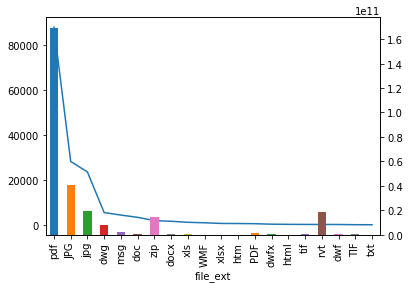

In [26]:
dir_plt_df['file_name'].plot()
dir_plt_df['size'].plot(kind='bar',secondary_y=True)

## Select features

Since the conversion of the PDF file contents to Text was very time comsuming, I decided not to use the file contents as the feature to build the classification model.

I use only two features: 1)file_name, and 2)size as the independent variables (X). For the dependent variable (y), I use the first 4 charactors of the file_path as the label for the file folders.

In [5]:
proj_dir_df['doc_label'] = proj_dir_df['file_path'].apply(lambda x: x[:4])

proj_dir_df['doc_label'].value_counts()

F.05    46454
F.01    26612
C.02    21465
F.03    18321
D.02    17388
F.02     8785
F.06     7912
D.01     3985
F.04     3263
A.01     3161
C.01     2220
E.01     2101
B.01      931
C.03      744
Ex_F      463
Z.01      209
G:\M        9
F.07        8
Name: doc_label, dtype: int64

## Cleaning up

The records with the "G:\M" and "Ex_F" values are removed form the dataset.

In [8]:
proj_dir_df = proj_dir_df[proj_dir_df['doc_label'] != "G:\M"]
proj_dir_df = proj_dir_df[proj_dir_df['doc_label'] != "Ex_F"]
proj_dir_df['doc_label'].value_counts()


F.05    46454
F.01    26612
C.02    21465
F.03    18321
D.02    17388
F.02     8785
F.06     7912
D.01     3985
F.04     3263
A.01     3161
C.01     2220
E.01     2101
B.01      931
C.03      744
Z.01      209
F.07        8
Name: doc_label, dtype: int64

In [19]:
data_df = proj_dir_df[['file_name','size','doc_label']]

## Split data to train and test datasets

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=.5, random_state = 0)

for train_index, test_index in sss.split(data_df[['file_name','size']],data_df[['doc_label']]):
    train_set = data_df.iloc[train_index]
    test_set = data_df.iloc[test_index]
    

 # Save train and test sets for future use
path = './data/'

file = "train_set.csv"
train_set.to_csv(path + file, index=False)   

file = "test_set.csv"
test_set.to_csv(path + file, index=False) 

In [22]:
len(train_set), len(test_set)

(102332, 27560)

# Latent Dirichlet Allocation (LDA)

The LDA techniques which is one of the Probabilistic inference algorithm for the topic modeling is used to numericalize the file_name field. The LDA method estimates the probability distribution of the file_name over the predefined set of topics. So after model fitting, the list of file_names can be transformed to a list prabability values which can then be used for classification models.

In [25]:
docs_raw = train_set['file_name'].tolist()

In [26]:
#import graphlab as gl
import pyLDAvis
import pyLDAvis.sklearn
#import pyLDAvis.graphlab

pyLDAvis.enable_notebook()

In [27]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [28]:
term_freq_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                      stop_words = 'english',
                                      lowercase = True,
                                      token_pattern = r'\b[a-zA-Z]{3,}\b',
                                      max_df = 0.5,
                                      min_df = 10)

dtm_tf = term_freq_vectorizer.fit_transform(docs_raw)
print(dtm_tf.shape)

(102332, 1826)


In [29]:
lda_tf = LatentDirichletAllocation(n_components=32, random_state=0)
lda_tf.fit(dtm_tf)

print(lda_tf.components_.shape)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


(32, 1826)


In [30]:
pyLDAvis.sklearn.prepare(lda_tf,dtm_tf,term_freq_vectorizer)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
31     0.292903  0.363882       1        1  10.652722
25    -0.130544  0.009336       2        1   6.497028
7     -0.277274  0.046400       3        1   6.158090
0     -0.158059  0.020042       4        1   4.467867
3     -0.120472  0.008662       5        1   4.282302
6     -0.064543 -0.011663       6        1   3.844498
24    -0.143632  0.014909       7        1   3.807986
13    -0.162197  0.020126       8        1   3.736239
4      0.184857 -0.127478       9        1   3.442533
2     -0.135607  0.010788      10        1   3.111720
22    -0.193813  0.027282      11        1   2.773321
11    -0.045713 -0.050514      12        1   2.748604
18     0.189338 -0.109742      13        1   2.642153
10    -0.139499  0.012763      14        1   2.602512
12    -0.123550  0.007132      15        1   2.551076
21    -0.091243 -0.005420      16        1   2.540805
5     -0.110664  0.003160      17        1   2.480000
17    -0.159362  0.017496      18        1   2.437145
29    -0.150985  0.015567      19        1   2.431246
16    -0.179200  0.022570      20        1   2.413047
14    -0.151380  0.014796      21        1   2.355634
28    -0.191222  0.025501      22        1   2.339666
20     0.286041  0.336478      23        1   2.296256
26     0.189537 -0.110660      24        1   2.218927
19     0.189245 -0.109932      25        1   2.178738
30     0.189665 -0.111342      26        1   2.057504
23     0.189935 -0.111602      27        1   2.003774
9      0.189727 -0.111528      28        1   1.943663
27     0.189578 -0.111676      29        1   1.894440
8      0.189580 -0.111862      30        1   1.771141
1      0.189689 -0.112412      31        1   1.692694
15     0.258863  0.218938      32        1   1.626668, topic_info=     Category          Freq       Term         Total  loglift  logprob
term                                                                  
885   Default  27657.000000        jpg  27657.000000  30.0000  30.0000
1182  Default  42324.000000        pdf  42324.000000  29.0000  29.0000
522   Default   3075.000000        dwg   3075.000000  28.0000  28.0000
1388  Default   3507.000000        rfi   3507.000000  27.0000  27.0000
1215  Default   3068.000000       plan   3068.000000  26.0000  26.0000
1072  Default   2424.000000        msg   2424.000000  25.0000  25.0000
663   Default   2450.000000      floor   2450.000000  24.0000  24.0000
1205  Default   1582.000000   pictures   1582.000000  23.0000  23.0000
482   Default   1826.000000        doc   1826.000000  22.0000  22.0000
1180  Default   1280.000000        pco   1280.000000  21.0000  21.0000
924   Default   2174.000000      level   2174.000000  20.0000  20.0000
278   Default   1272.000000      clark   1272.000000  19.0000  19.0000
1355  Default   1469.000000     report   1469.000000  18.0000  18.0000
1591  Default   1093.000000  submittal   1093.000000  17.0000  17.0000
450   Default   1257.000000    details   1257.000000  16.0000  16.0000
1382  Default   1019.000000     review   1019.000000  15.0000  15.0000
1713  Default   1115.000000       umcp   1115.000000  14.0000  14.0000
1824  Default   1081.000000        zip   1081.000000  13.0000  13.0000
94    Default   1339.000000        asi   1339.000000  12.0000  12.0000
487   Default   1021.000000       docx   1021.000000  11.0000  11.0000
190   Default   1221.000000        bsu   1221.000000  10.0000  10.0000
1479  Default    920.000000       shop    920.000000   9.0000   9.0000
1290  Default    976.000000        psc    976.000000   8.0000   8.0000
643   Default   1127.000000      final   1127.000000   7.0000   7.0000
238   Default    910.000000       ccit    910.000000   6.0000   6.0000
757   Default    924.000000       hall    924.000000   5.0000   5.0000
1145  Default    895.000000    package    895.000000   4.0000   4.0000
502   Default    838.000000   drawings    838.000000   3.0000 

## Assemble the X_train and y_train sets

In [31]:
X_lda_trans = lda_tf.transform(dtm_tf)
X_lda_trans.shape

(102332, 32)

In [33]:
file_size_list = train_set['size'].tolist()
file_size_np = np.array(file_size_list).reshape(-1,1)
file_size_np.shape

X_train = np.hstack((X_lda_trans,file_size_np)) 
y_train = train_set['doc_label'].tolist()

print(X_train.shape,len(y_train))

(102332, 33) 102332


## Scale and Linear Discriminant Analysis (LDA) transform

Standard scaling is required for many classification methods. It will imporve the performance of the classifer.

On the other hand, LDA transforms the space into a fewer dimensions which can explain the majority of the information embeded in the data in respect to the sample data labels. 

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_train)
y = y_train

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 3)

X_lda = lda.fit_transform(X_sc,y)


D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Text(0.5,1,'LDA')

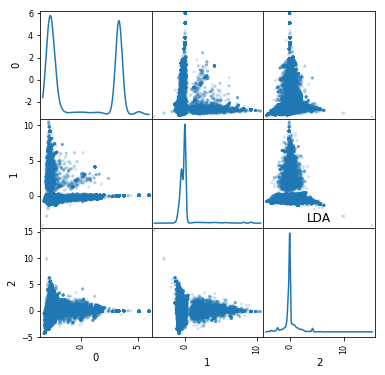

In [48]:
from pandas.plotting import scatter_matrix

scatter_matrix(pd.DataFrame(X_lda), alpha=0.2, figsize=(6, 6), diagonal='kde')

#plt.scatter(X_lda[:,1],X_lda[:,2], s=50)

#plt.scatter(centroids_lda[:, 0], centroids_lda[:, 1], c='black', s=200, alpha=0.5)
#plt.title('LDA')

In [49]:
lda.explained_variance_ratio_

array([ 0.83339572,  0.07014686,  0.02934738])

# Ensembling a stacked model

I picked the following three models based on their fair performances for the following stacked model. I will then fit the model to find the best hyper (hard) parameters and soft parameters.

Stacked model:
<br>
- Level (1)
    - Model #1 Random Forest
    - Model #3 Linear SVM
    - Model #5 AdaBoost    
<br>
- Level (2): Blending Model
    - Model #2 Logistic Regression
    

In [51]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Setup a new training and test set for training the level (1) models

In [62]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X_lda, y_train, test_size=0.6, random_state=42)

print(X1_train.shape, len(y1_train))
print(X1_test.shape, len(y1_test))

(40932, 3) 40932
(61400, 3) 61400


## Fine tunning the level (1) models using GridSearchCV (cv=10)

### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)

param_grid = { 
    'max_features': ['auto', 'log2'], \
    'max_depth' : [5,15], \
    'min_samples_leaf' : [1] , 'min_samples_split' : [2], \
    'criterion' :['gini']}

grid_search = GridSearchCV(rfc, param_grid=param_grid, cv = 10, \
                           scoring = make_scorer(accuracy_score), n_jobs=4, refit = True)

grid_search.fit(X1_train, y1_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_features': ['auto', 'log2'], 'max_depth': [5, 15], 'min_samples_leaf': [1], 'min_samples_split': [2], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [64]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [67]:
rfc = grid_search.best_estimator_

print("Random Forest Classifier:")
start_time = time.time()
rfc.fit(X1_train, y1_train)
elapsed_time = time.time() - start_time
print(elapsed_time)
print("Accuracy: %8.2f" % (rfc.score(X1_test, y1_test)))
print(classification_report(y1_test, rfc.predict(X1_test)))

Random Forest Classifier:
0.7480428218841553
Accuracy:     0.71
             precision    recall  f1-score   support

       A.01       0.49      0.33      0.40       976
       B.01       0.34      0.11      0.16       265
       C.01       0.35      0.14      0.20       672
       C.02       0.71      0.73      0.72      6445
       C.03       0.38      0.19      0.26       222
       D.01       0.32      0.13      0.19      1166
       D.02       0.37      0.39      0.38      5253
       E.01       0.25      0.06      0.10       642
       F.01       0.47      0.48      0.47      8201
       F.02       0.66      0.69      0.67      2576
       F.03       0.53      0.62      0.57      5565
       F.04       0.69      0.68      0.68       939
       F.05       0.94      0.99      0.96     25986
       F.06       0.52      0.38      0.44      2427
       F.07       0.00      0.00      0.00         4
       Z.01       0.92      0.20      0.32        61

avg / total       0.70      0.71 

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Linear SVM

In [68]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC(C = 1.0)

param_grid = {'C': [0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(lsvm, param_grid=param_grid, cv = 10, \
                           scoring = make_scorer(accuracy_score), n_jobs=-1, refit = True)

grid_search.fit(X1_train, y1_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [69]:
grid_search.best_params_

{'C': 1}

In [71]:
lsvm = grid_search.best_estimator_

print("Linear SVM classifier:")
start_time = time.time()
lsvm.fit(X1_train, y1_train)
elapsed_time = time.time() - start_time
print(elapsed_time)
print("Accuracy: %8.2f" % (lsvm.score(X1_test, y1_test)))
print(classification_report(y1_test, lsvm.predict(X1_test)))

Linear SVM classifier:
47.53923177719116
Accuracy:     0.59
             precision    recall  f1-score   support

       A.01       0.00      0.00      0.00       976
       B.01       0.00      0.00      0.00       265
       C.01       0.00      0.00      0.00       672
       C.02       0.29      0.76      0.42      6445
       C.03       0.00      0.00      0.00       222
       D.01       0.00      0.00      0.00      1166
       D.02       0.00      0.00      0.00      5253
       E.01       0.00      0.00      0.00       642
       F.01       0.28      0.46      0.35      8201
       F.02       0.61      0.70      0.65      2576
       F.03       0.00      0.00      0.00      5565
       F.04       0.00      0.00      0.00       939
       F.05       0.92      1.00      0.96     25986
       F.06       0.00      0.00      0.00      2427
       F.07       0.00      0.00      0.00         4
       Z.01       0.00      0.00      0.00        61

avg / total       0.48      0.59     

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### AdaBoost

In [73]:
# AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_boost = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5), n_estimators=200,
    learning_rate=0.5, random_state=42)

param_grid = {'base_estimator__criterion': ["gini"], \
              'base_estimator__splitter' :   ["best"], \
              'base_estimator__max_depth' :   [5], \
              'learning_rate': [0.01], 'n_estimators': [100,200]}

grid_search = GridSearchCV(ada_boost, param_grid=param_grid, cv = 10, \
                           scoring = make_scorer(accuracy_score), n_jobs=4, refit = True)

grid_search.fit(X1_train, y1_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'base_estimator__criterion': ['gini'], 'base_estimator__splitter': ['best'], 'base_estimator__max_depth': [5], 'learning_rate': [0.01], 'n_estimators': [100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [74]:
grid_search.best_params_

{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 5,
 'base_estimator__splitter': 'best',
 'learning_rate': 0.01,
 'n_estimators': 100}

In [77]:
ada_boost = grid_search.best_estimator_

print("AdaBoost classifier:")
start_time = time.time()
ada_boost.fit(X1_train, y1_train)
elapsed_time = time.time() - start_time
print(elapsed_time)
print("Accuracy: %8.2f" % (ada_boost.score(X1_test, y1_test)))
print(classification_report(y1_test, ada_boost.predict(X1_test)))

AdaBoost classifier:
17.76134705543518
Accuracy:     0.65
             precision    recall  f1-score   support

       A.01       0.52      0.01      0.02       976
       B.01       0.00      0.00      0.00       265
       C.01       1.00      0.00      0.01       672
       C.02       0.53      0.67      0.59      6445
       C.03       0.00      0.00      0.00       222
       D.01       0.00      0.00      0.00      1166
       D.02       0.31      0.18      0.23      5253
       E.01       0.00      0.00      0.00       642
       F.01       0.34      0.56      0.42      8201
       F.02       0.65      0.70      0.67      2576
       F.03       0.42      0.47      0.44      5565
       F.04       1.00      0.31      0.48       939
       F.05       0.94      0.98      0.96     25986
       F.06       0.80      0.00      0.01      2427
       F.07       0.00      0.00      0.00         4
       Z.01       0.00      0.00      0.00        61

avg / total       0.66      0.65      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Blending Model

In [78]:
x2_adaboost = ada_boost.predict(X1_test)
x2_rfc = rfc.predict(X1_test)
x2_lsvm = lsvm.predict(X1_test)

In [79]:
x2_adaboost = np.array(x2_adaboost).ravel().reshape(-1,1)
x2_rfc = np.array(x2_rfc).ravel().reshape(-1,1)
x2_lsvm = np.array(x2_lsvm).ravel().reshape(-1,1)

In [80]:
x2_adaboost.shape,x2_rfc.shape,x2_lsvm.shape

((61400, 1), (61400, 1), (61400, 1))

In [81]:
x2 = np.hstack((x2_adaboost,x2_rfc,x2_lsvm))
x2.shape

(61400, 3)

In [85]:
x2.shape, len(y1_test)

((61400, 3), 61400)

### Fit the blending model (Model level 2)

In [99]:
x2, x2.shape

(array([['F.05', 'F.05', 'F.05'],
        ['F.05', 'F.05', 'F.05'],
        ['F.01', 'F.06', 'F.01'],
        ..., 
        ['D.02', 'D.02', 'C.02'],
        ['F.01', 'F.06', 'F.01'],
        ['F.05', 'F.05', 'F.05']], 
       dtype='<U4'), (61400, 3))

In [97]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
x2_lb = le.fit_transform(x2.ravel())


In [98]:
le.classes_

array(['A.01', 'B.01', 'C.01', 'C.02', 'C.03', 'D.01', 'D.02', 'E.01',
       'F.01', 'F.02', 'F.03', 'F.04', 'F.05', 'F.06', 'Z.01'], 
      dtype='<U4')

In [105]:
x2_lb = x2_lb.reshape(x2.shape)

In [106]:
x2_lb

array([[12, 12, 12],
       [12, 12, 12],
       [ 8, 13,  8],
       ..., 
       [ 6,  6,  3],
       [ 8, 13,  8],
       [12, 12, 12]], dtype=int32)

In [107]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)

logreg.fit(x2_lb, y1_test)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Test the stacked model

### Transform X_test

In [131]:
docs_raw_test = test_set['file_name'].tolist()
dtm_tf_test = term_freq_vectorizer.transform(docs_raw_test)

X_lda_trans_test = lda_tf.transform(dtm_tf_test)


file_size_list = test_set['size'].tolist()
file_size_np = np.array(file_size_list).reshape(-1,1)
file_size_np.shape

X_test = np.hstack((X_lda_trans_test,file_size_np)) 
y_test = test_set['doc_label'].tolist()

In [132]:
X_test_sc= scaler.transform(X_test)
X_test = lda.transform(X_test_sc)

In [133]:
x2_adaboost = ada_boost.predict(X_test)
x2_rfc = rfc.predict(X_test)
x2_lsvm = lsvm.predict(X_test)

In [134]:
x2_adaboost = np.array(x2_adaboost).ravel().reshape(-1,1)
x2_rfc = np.array(x2_rfc).ravel().reshape(-1,1)
x2_lsvm = np.array(x2_lsvm).ravel().reshape(-1,1)

x2 = np.hstack((x2_adaboost,x2_rfc,x2_lsvm))

In [135]:
x2_lb = le.fit_transform(x2.ravel()).reshape(x2.shape)
x2_lb

array([[ 8,  8,  3],
       [ 8,  8,  8],
       [ 8,  8,  3],
       ..., 
       [ 9,  9,  9],
       [11, 11,  3],
       [10,  6,  8]], dtype=int32)

### Predict X_test

In [136]:
y_pred = logreg.predict(x2_lb)

In [137]:
y_pred.shape

(27560,)

In [138]:
len(y_test)

27560

In [139]:
#print("Accuracy: %8.2f" % (rfc.score(X1_train, y1_train)))
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       A.01       0.00      0.00      0.00       963
       B.01       0.00      0.00      0.00       284
       C.01       0.00      0.00      0.00       676
       C.02       0.54      0.79      0.64      6536
       C.03       0.00      0.00      0.00       227
       D.01       0.00      0.00      0.00      1214
       D.02       0.00      0.00      0.00      5295
       E.01       0.00      0.00      0.00       640
       F.01       0.00      0.00      0.00         0
       F.02       0.22      0.00      0.00      2675
       F.03       0.39      0.44      0.41      5579
       F.04       0.00      0.00      0.00       994
       F.05       0.00      0.00      0.00         0
       F.06       0.38      0.00      0.01      2410
       F.07       0.00      0.00      0.00         3
       Z.01       0.00      0.00      0.00        64

avg / total       0.26      0.28      0.24     27560



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Conclusion

It seems the single classification models perform better that the stacked model.

The best single model was found the random forest. (I am a bit skeptical that the model is overfitted to the train dataset!!!)

## Future Work

I am going to extract the text contents of the files to see if it induces any improvement.